# Non-Stationary Contextual Bandits Evaluation

In this notebook we will build a simple setting (contextual bandits) to understand how a non-stationary policy should be evaluated. 

#### Contextual bandits
We introduce a contextual bandit with 2 arms, where the choice of its actions $a_t\in\{0,1\}$ also depends on its context $x_t$, which is sampled from a Context distribution $\mathcal{D}$. Since we want a non-stationary contextual bandit, this distribution will change smoothly over time, so the context is sampled from a time-dependend distribution $x_t\sim\mathcal{D}_t$.
Moreover, at each time $t$ the policy parameter will be given by a time-dependent hyperpolicy $\nu$ that is tuned with the hyperparameters $\rho$.

#### Problem definition 
Let's define the non-stationary process that builds the context distributions $\mathcal{D}_t$ as a sinusoidal one, i.e. we have $\mathcal{D}_t = \mathcal{N}(\mu_x(t),\sigma_x)$ with $\mu_x(t) = A_x\sin(\phi_x t + \psi_x) + B_x$ and a constant $\sigma_x$. We want the agent to recognise if $\mu_x(t)>0$ (corresponding to $a_t=0$) or if $\mu_x(t)<0$ (corresponding to $a_t=1$). The rewards can assume only 2 values (0 and 1) and are sampled from a Bernoully distribution with a parameter depending on the action, i.e $R(x_t, a) \sim \mathcal{B}(\tilde{\mu}_a) = (1-\tilde{\mu}_a, \tilde{\mu}_a)$ with $\tilde{\mu}_{a=0} = \frac{1}{2} \left( 1 + \frac{\mu_x(t)-B_x}{A_x} \right)$ if $a=0$ and $\tilde{\mu}_{a=1} = \frac{1}{2} \left( 1 - \frac{\mu_x(t)-B_x}{A_x} \right)$ if $a=1$. In order to handle the non-stationary process, the hyperpolicy needs to be based on a similar sinusoidal process, and its goal should be learning and replicating the non-stationary process (thus $\theta_t \simeq \mu_x(t)$) in order to maximize the rewards.

In the end, the bandit can be represented in two ways, depending on the desired approach:
 - **Action-based exploration**: The stochasticity is given by the policy, which will be represented by a Bernoulli distribution $\pi_{\theta_t}(a_t|x_t) = \left(1-p_t, p_t\right)$, where $p_t \equiv f(\theta_t, x_t) = S(x_t-\theta_t)$ (with $S(x)$ the sigmoid function) and $\theta_t \sim \nu_\rho(\theta_t|t)$. In this case, the hyperpolicy is deterministic and, at each $t$, the value of $\theta_t$ is given by $\theta_t = \nu_\rho(t) = A_\theta\sin(\phi_\theta t + \psi_\theta) + B_\theta$.
 - **Parameter-based exploration**: The stochasticity is given by the hyperpolicy, which is represented by a time-dependent gaussian distribution $\nu_\rho(\theta_t|t) = \mathcal{N}(\mu_\theta(t),\sigma_\theta)$ with $\mu_\theta(t) = A_\theta\sin(\phi_\theta t + \psi_\theta) + B_\theta$ and a constant $\sigma_\theta$. The sampled $\theta_t$ will now define a deterministic policy $\pi_{\theta_t}(x_t)$, which will be represented by a step function centered in $(x_t-\theta_t)$ and will be equal to $1$ if $x_t>\theta_t$ and $0$ if $x_t<\theta_t$.

In [428]:
# Import libraries
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Environment definition

Start by defining the environment that contains the non-stationary context and that assigns rewards for each action of the bandit.

In [440]:
class environment:
    
    ### Define the environment: NS_context=True  -> non-stat context distribution    
    ###                         NS_context=False -> non-stat reward function
    ###                         remove_contexts -> x_t=0 always, reward function becomes non-stat
    def __init__(self, sigma_x, NS_context, t0=0, remove_context=False, **kwargs):
        
        # Store the given parameters
        self.t = t0
        self.sigma_x = sigma_x
        self.remove_context = remove_context
        
        # If we don't want to use context, use a non-stat reward function
        if remove_context:
            self.NS_context = False
        else:
            self.NS_context = NS_context
        
        # if params that define the mean are not given, take random ones
        self.var_names = ['A', 'phi', 'psi'] 
        for var in self.var_names:
            if var in kwargs.keys():
                setattr(self, var, kwargs[var])
            else:
                setattr(self, var, np.random.rand())
    

    
    ### Definition of the non-stationary process: 
    ###    If NS_context = True,  it defines the mean of the context distribution
    ###    If NS_context = False, it defines a term in the reward function
    def non_stat_process(self, t):
        return self.A * np.sin(self.phi*t + self.psi)
        
    
    
    ### Compute the context mean at present timestep 'self.t'. If context distr is 
    ### stationary or if x_t is fixed to 0, the mean is always equal to 0
    def x_mean(self, t=None):
        if self.remove_context or not(self.NS_context):
            return 0
        else:
            return self.non_stat_process(self.t)

        
    ### Sample a context from the distibution at time 'self.t'
    def sample_x(self):
        if self.remove_context:
            return 0
        else:
            return scipy.stats.norm.rvs(loc   = self.x_mean(), 
                                        scale = self.sigma_x)
    
    
    
    
    ### Sample reward from a Bernoulli distribution that depends on the action and the context; 
    ### The parameter is computed differently if we have non-stat contexts or non-stat rewards
    def get_reward(self, x, action, get_p=False):
        
        # Compute bernoulli parameter for the correct case
        if self.NS_context:
            p_t = sigmoid( x - self.x_mean() )
        else:
            initial_reward = self.non_stat_process(self.t)
            p_t = sigmoid( x + initial_reward )
        
        # If we want to study the distributions, return parameter instead of reward
        if get_p:
            return p_t
        
        # Sample a reward given the chosen action
        if action:
            return scipy.stats.bernoulli.rvs(p_t)
        else:
            return scipy.stats.bernoulli.rvs(1 - p_t)
            
            
    
    
    ### Use the hyperpolicy nu to perform many subsequent steps
    ### Returns the evolution of many variables
    def play(self, nu, n_steps, get_p=False):
        
        contexts = np.array([])
        thetas   = np.array([])
        rewards  = np.array([])
        context_means = np.array([])
        theta_means   = np.array([])
    
        # At each timestep...
        for i in range(n_steps):
            
            # Sample a policy from the hyperpolicy 
            # (given t and the tipe of non-stationarity)
            policy = nu.sample_policy(self.t, self.NS_context)
            
            # Sample a context from the corresponding distribution
            x_t = self.sample_x()
            
            # Perform a step sampling the action from current policy 
            action = policy.action(x_t)
            reward = self.get_reward(x_t, action, get_p)
            
            # Update time variable
            self.t += 1
            
            # Store current values in the arrays
            contexts = np.append(contexts, x_t)
            thetas   = np.append(thetas, policy.theta)
            rewards  = np.append(rewards, reward)
            context_means = np.append(context_means, self.x_mean())
            theta_means   = np.append(theta_means, nu.theta_mean(self.t))

        return contexts, thetas, rewards, context_means, theta_means

## Policy definition

Here we will define the policy class following the structure described at the beginning of the notebook. The action is given by a bool variable (`True` if policy thinks that $x_t>\mu_x(t)$, `False` otherwise). 

If `stochastic = True`, the policy sample the action from the Bernoulli distribution centered in $x_t-\theta_t$, otherwise the policy is just a step function centered in the same quantity.

In [441]:
class policy_class:
    
    ### Theta is the only param and reprsents an estimate of the non-stat 
    ### process of the environment (that represent different )
    def __init__(self, theta, NS_context, stochastic=True):
        self.theta = theta
        self.stochastic = stochastic
        self.NS_context = NS_context
    
    ### Return the bernoulli distr over the actions given the context
    ### (makes sense only if policy is stochastic, i.e. action-based case)
    def bernoulli_distr(self, x):
        if self.NS_context:
            p = sigmoid(x - self.theta)
        else:
            p = sigmoid(x + self.theta)
        return (1-p,p)
        
     
    ### Choose action given the sampled context (and depending on the problem)
    def action(self, x):
        
        ### IF env has nonstationary Context distribution,
        ### action = 1 has higher prob (or chosen) if x-theta > 0
        if self.NS_context:
            if self.stochastic:
                p = sigmoid(x - self.theta)
                return scipy.stats.bernoulli.rvs(p)
            else:
                return (x - self.theta > 0)
            
        ### IF env has nonstationary reward function,
        ### action = 1 has higher prob (or chosen) if x+theta > 0
        else:
            if self.stochastic:
                p = sigmoid(x + self.theta)
                return scipy.stats.bernoulli.rvs(p)
            else:
                return (x + self.theta > 0)

## Hyperpolicy definition

Here we will define the hyperpolicy class following the structure described at the beginning of the notebook. If `param_based = True`, the hyperpolicy will be stochastic and will sample the $\theta_t$ value from the gaussian distribution with a time dependent mean $\mu(t)$, otherwise we just have $\theta_t = \mu(t)$.

In [505]:
class hyperpolicy:
        
    def __init__(self, sigma_theta, param_based=True, **kwargs):
        
        # Store the given parameters
        self.sigma_theta = sigma_theta
        self.stochastic = param_based
        
        # if params that define the mean are not given, take random ones        
        self.var_names = ['A', 'phi', 'psi'] 
        for var in self.var_names:
            if var in kwargs.keys():
                setattr(self, var, kwargs[var])
            else:
                setattr(self, var, np.random.rand())
               
            
    
    def theta_mean(self, t):
        return self.A * np.sin(self.phi*t + self.psi)
    
        
    def theta_pdf(self, theta, t):
        return scipy.stats.norm.pdf(theta, loc=self.theta_mean(t), scale=self.sigma_theta)
    
    
    def sample_theta(self, t):
        if self.stochastic:
            return scipy.stats.norm.rvs(loc=self.theta_mean(t), scale=self.sigma_theta)
        else:
            return self.theta_mean(t)
        
        

    def sample_policy(self, t, NS_context):
        theta = self.sample_theta(t)
        return policy_class(theta, NS_context, not(self.stochastic) )
    
    
    #def update_params(self, delta_params):
        
        # TO DO
        

# Test environment

Tune the problem changing:
 - `param_based`: If True we will have a stochatic hyperpolicy (gaussian with time-dependent mean) and a deterministic policy (given by a step function centered on the sampled $\theta$), if False we will have a deterministic hyperpolicy ($\theta$ is a function of time) and a stochastic policy (action sampled from bernoulli distribution instead of given by a step function).
 - `NS_context`: If True, the environment will present a non-stationary context distribution, and the reward will be 1 with a higher probability if the bandit recognises if $x_t\lessgtr\mu_x(t)$. If False the environment will present a non-stationary reward function that will also depend on the context, reward will be 1 with a higher probability if the bandit recognises if $x_t+\mu_r(t)\lessgtr0$. in both case the non-stationary process is represented by $\mu(t)=A\sin(\phi t + \psi)$. The choice of problem will also impact the policy behaviours (but will not affect the hyperpolicy).
 - `remove_context`: If True, the context will be always equal to zero. In this case the problem is forced to have a non-stationary reward function.
 - `get_p`: the `play` method will not return the collected reward at each step, but it will return the bernoulli parameter that td 

In [506]:
# Get random hyperpolicy
nu  = hyperpolicy(sigma_theta=1, param_based=True, 
                  A=5, phi=0.1, psi=np.pi)

# Initialize environment and the type of problem
env = environment(sigma_x=2, NS_context=False, remove_context=False,
                  A=5, phi=0.1, psi=np.pi)

# Play the hyperpolicy
contexts, thetas, rewards, context_means, theta_means = env.play(nu, n_steps=140, get_p=True)

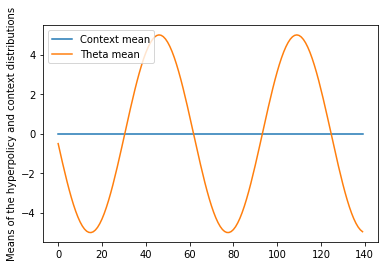

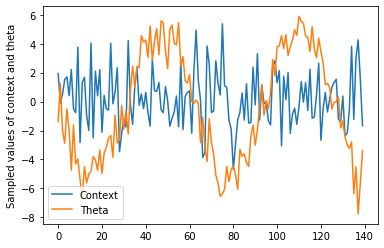

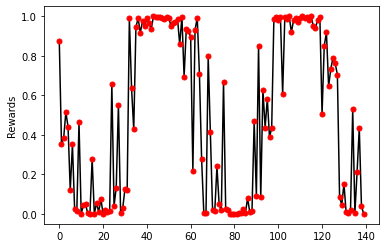

In [507]:
# Plot the evolution of everything
plt.plot(context_means, label="Context mean")
plt.plot(theta_means, label="Theta mean`")
plt.ylabel("Means of the hyperpolicy and context distributions")
plt.legend()
plt.show()

plt.plot(contexts, label="Context")
plt.plot(thetas, label="Theta")
plt.ylabel("Sampled values of context and theta")
plt.legend()
plt.show()

plt.plot(rewards, c='black')
plt.plot(np.where(rewards>0)[0],  rewards[rewards>0],  'ro', markersize=5)
plt.plot(np.where(rewards==0)[0], rewards[rewards==0], 'bo', markersize=5)
plt.ylabel("Rewards")
plt.show()

## Performance estimators
The quantity that we wish to estimate and maximize is the following
$$J=\mathbb{E}_{\nu_\rho(\cdot\vert t+1)} \left[\left. \sum_{i=t+1}^{\infty} \gamma^i R_i \right\vert s_t \right]$$

So, at each timestep, We use the non-stationary policy to estimate the performance of the policy at time $t+1$. We regularize by using importance sampling and, to be specific, we will use MIS-based estimators because the hyperpolicy $\nu_\rho(t)$ changes at each timestep. The "plain" MIS estimator is
$$ \hat{J}=\frac{1}{\alpha}\sum_{i=t-\alpha}^{t}R_i \frac{\nu_\rho(\theta_i\vert t+1)}{\nu_\rho(\theta_i\vert i)} $$

To test the estimator, `return_type=0` will return the estimated performance, `return_type=1` will return the weigthed rewards, and `return_type=2` will return the Importance Sampling weights

In [520]:
def MIS_estimator(nu, thetas, rewards, t, return_type=0):
    
    
    # Check if rewards and thetas have the same lenght
    if len(thetas) != len(rewards):
        print("\n ----- Thetas and rewards have different lengths ----- \n")
        return None

    # Given present time t, get time of past rewards
    t0 = (t+1) - len(rewards)
    timesteps = np.arange(t0, t+1)
    
    # Compute the weighted rewards inside the time window
    # IF we are interested in the weights, don't compute weighted rewards
    terms = np.array([]) 

    for i in timesteps:
        IS_weight = nu.theta_pdf(thetas[i-t0], t+1) / nu.theta_pdf(thetas[i-t0], i)
        if return_type == 2:
            terms = np.append(terms, IS_weight )
        else:
            IS_reward = rewards[i-t0] * IS_weight / len(rewards)
            terms = np.append(terms, IS_reward)
    
    # If we are interested in just the estimated performance, sum the weighted rewards
    if return_type == 0:
        return np.sum(terms)
    else:
        return terms

### Test Performance Estimator

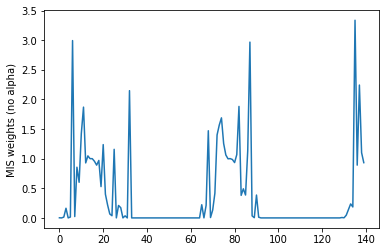

In [526]:
### Study the behaviour of the different terms of the MIS estimator on the last
### timestep using the all the collected rewards and policies (i.e. alpha=t)

# Shift rewards to make them positive (for IS)
shifted_rewards = rewards + 0

# MIS estimator using all the available data
t = len(rewards)
MIS_terms = MIS_estimator(nu, thetas[:], shifted_rewards[:], t, return_type=2)

# Plot the terms to see how they impact the performance estimation
plt.plot(MIS_terms)
plt.ylabel("MIS weights (no alpha)")
plt.show()

In [524]:
sum(MIS_terms)

52.19647229133018